In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# !kaggle datasets download -d robervalt/sunspots -p ./data
# !unzip -q ./data/sunspots.zip -d ./data

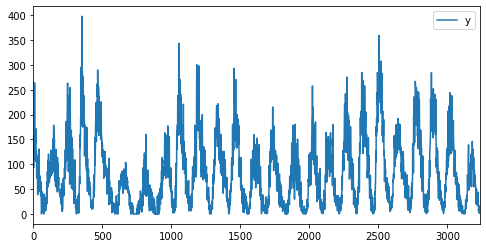

In [3]:
df_data = pd.read_csv('./data/Sunspots.csv', index_col=0, skiprows=1, names=['ds', 'y'])
df_data.plot(figsize=(8, 4))

In [4]:
TRAIN_VAL_SPLIT = 3000
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFER_BUFFER_SIZE = 1000

In [5]:
df_train = df_data[:TRAIN_VAL_SPLIT]
df_val = df_data[TRAIN_VAL_SPLIT:]

In [6]:
def build_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
dataset_train = build_dataset(df_train['y'].values, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda

def build_model():
    model = Sequential([
        Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
        LSTM(64, return_sequences=True),
        LSTM(64, return_sequences=True),
        Dense(30, activation="relu"),
        Dense(10, activation="relu"),
        Dense(1),
        Lambda(lambda x: x * 400)
    ])
    return model

In [9]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from util import clear_env

clear_env()

model = build_model()
model.compile(loss=Huber(), optimizer=SGD(lr=1e-8, momentum=0.9), metrics=['mae'])

def learning_rate(epoch):
    return 1e-8 * 10**(epoch / 20)

lr_scheduler = LearningRateScheduler(learning_rate)

history = model.fit(dataset_train, epochs=100, callbacks=[lr_scheduler], verbose=0)

W0810 17:04:40.621026  8760 deprecation.py:323] From d:\Dev\Miniconda3\envs\tf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[1e-08, 0.0001, 0, 60]

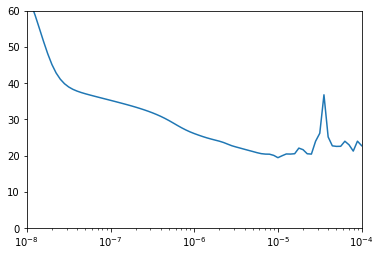

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Select learning rate = 1e-5.

In [11]:
clear_env()

model = build_model()
model.compile(loss=Huber(), optimizer=SGD(lr=1e-5, momentum=0.9), metrics=['mae'])
history = model.fit(dataset_train, epochs=100, verbose=0)

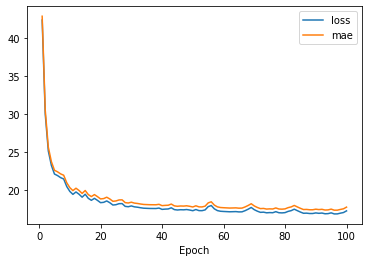

In [12]:
from util import plot_history, validate_model

plot_history(history, metrics=['loss', 'mae'])

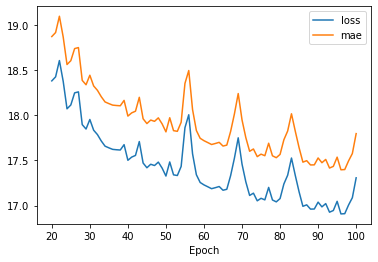

In [13]:
plot_history(history, start_epoch=20, metrics=['loss', 'mae'])

MSE: 216.95672669361133, MAE: 10.3987976968637


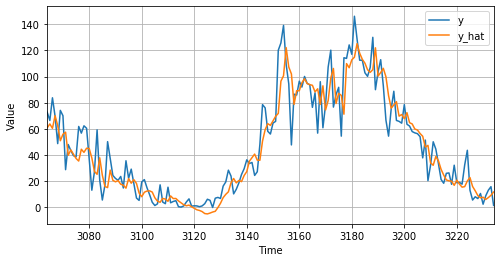

In [14]:
from util import validate

def build_test_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return ds

def validate_model(model, df_val, window_size):
    dataset_val = build_test_dataset(df_val['y'].values, WINDOW_SIZE)
    forecast = model.predict(dataset_val)
    df_forecast = df_val.copy()
    df_forecast['y_hat'] = np.nan
    df_forecast.iloc[window_size:, df_forecast.columns.get_loc('y_hat')] = forecast[:-1, -1, 0]
    validate(df_forecast[window_size:])
    
validate_model(model, df_val, WINDOW_SIZE)